$\textbf{NOTE: Please run this notebook in jupyter notebook!!}$

## $\text{Importing Necessary Libraries}$

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'

## $\text{Defining All Functions Below}$

In [ ]:
#Theoretical Formulas are first defined -----------------------------

def s(omega_m):
    return ((1-omega_m)/omega_m)**(1/3)

def eta(a,omega_m):
    term_1 = (1/a**(4)) - (0.1540*s(omega_m)/(a**(3))) + (0.4304*(s(omega_m)**2)/(a**(2)))
    term_2 = (0.19097*(s(omega_m)**3)/(a**(1))) + (0.066941*(s(omega_m)**4))

    return 2*np.sqrt((s(omega_m)**3) + 1)*((term_1 + term_2)**(-1/8))

## Luminosity Distance -----------------------------

def lum_dist(c,h,z,omega_m):
    term_1 = eta(1,omega_m)
    term_2 = eta((1/(1+z)),omega_m)
    H0 = 100*h

    return (c*(1+z)/H0)*(term_1 - term_2)

## Distance Modulus -----------------------------

def dist_mod(c,h,z,omega_m):
    mu = 25 - (5*np.log10(h)) + (5*np.log10(lum_dist(c,1,z,omega_m)))
    return mu

# Likelihood is now defined! This is actually the "Log Likelihood" ------------------
def likelihood(c,h,z,omega_m,mu_obs,cov_inv):
    expo_val = 0

    if h <= 0.0 or omega_m <= 0.0 or h >= 1.0 or omega_m >= 1.0:
        return -np.inf
    else:
        mu_theo = dist_mod(c,h,z,omega_m)

        for i in range(len(z_vals)):
            for j in range(len(z_vals)):
                expo_val += (mu_obs[i]-mu_theo[i])*cov_inv[i,j]*(mu_obs[j]-mu_theo[j])

        return -0.5*expo_val


# Markov Chain Monte Carlo - Metropolis Hastings Algorithm is defined below ---------

def mcmh(init_h,init_o,sigma,n_steps,c,z_vals,mu_vals_obs,covar_inv,likelihood):
    burn_in = int(0.1*n_steps)

    h_vals = np.zeros(n_steps)
    omega_vals = np.zeros(n_steps)

    h_vals[0] = init_h
    omega_vals[0] = init_o
    n_accept = 0

    for i in range(1,n_steps):
        current_h = h_vals[i-1]
        proposed_h = np.random.normal(current_h,sigma)

        current_omega = omega_vals[i-1]
        proposed_omega = np.random.normal(current_omega,sigma)

        num = likelihood(c,proposed_h,z_vals,proposed_omega,
                         mu_vals_obs,covar_inv)*np.random.normal(0.738,0.024)
        den = likelihood(c,current_h,z_vals,current_omega,
                         mu_vals_obs,covar_inv)*np.random.normal(0.738,0.024)

        if num > den:
            h_vals[i] = proposed_h
            omega_vals[i] = proposed_omega
            n_accept += 1
        else:
            prob_accept = min(1,np.exp(-den+num))
            alpha = np.random.uniform()

            if alpha <= prob_accept: #Accept the probability
                h_vals[i] = proposed_h
                omega_vals[i] = proposed_omega
                n_accept += 1
            elif alpha > prob_accept:
                h_vals[i] = current_h
                omega_vals[i] = current_omega

    final_omega_vals = omega_vals#[burn_in:]
    final_h_vals = h_vals#[burn_in:]

    return final_omega_vals,final_h_vals, n_accept/n_steps

## $\textit{Part 1: Importance Sampling} $

In [ ]:
data = np.loadtxt("file1.txt")
covar = np.loadtxt("file_cov.txt")

z_vals = data[:,0]
mu_vals_obs = data[:,1]
covar = covar.reshape(31,31)
covar_inv = np.linalg.inv(covar)

n_steps = 1000
c = 3*(10**5)
sigma = 0.01

h_init = [0.05,0.05,0.95,0.95]#np.random.uniform(size=4)#.normal(0.738,0.024,size=4)
o_init = [0.05,0.95,0.05,0.95]#np.random.uniform(size=4)

omega_vals_1,h_vals_1,ar_1 = mcmh(h_init[0],o_init[0],sigma,n_steps,
                                  c,z_vals,mu_vals_obs,covar_inv,likelihood)
omega_vals_2,h_vals_2,ar_2 = mcmh(h_init[1],o_init[1],sigma,n_steps,
                                  c,z_vals,mu_vals_obs,covar_inv,likelihood)
omega_vals_3,h_vals_3,ar_3 = mcmh(h_init[2],o_init[2],sigma,n_steps,
                                  c,z_vals,mu_vals_obs,covar_inv,likelihood)
omega_vals_4,h_vals_4,ar_4 = mcmh(h_init[3],o_init[3],sigma,n_steps,
                                  c,z_vals,mu_vals_obs,covar_inv,likelihood)

### $\text{Plotting and Animating the data}$

In [ ]:
x1_data = omega_vals_1
y1_data = h_vals_1

x2_data = omega_vals_2
y2_data = h_vals_2

x3_data = omega_vals_3
y3_data = h_vals_3

x4_data = omega_vals_4
y4_data = h_vals_4

fig, ax = plt.subplots(figsize=(14,8),dpi=120)

ax.plot(x1_data[0], y1_data[0], 'bo',alpha=.5, ms=4,
        label="RW 1 - ($h_0=0.95,\Omega_{m0}=0.05$) ")

ax.plot(x2_data[0], y2_data[0], 'ro',alpha=.5, ms=4,
        label="RW 2 - ($h_0=0.05,\Omega_{m0}=0.05$) ")

ax.plot(x3_data[0], y3_data[0], 'go',alpha=.5, ms=4,
        label="RW 3 - ($h_0=0.05,\Omega_{m0}=0.95$) ")

ax.plot(x4_data[0], y4_data[0],'o',color='orange',alpha=.5, ms=4,
        label="RW 4 - ($h_0=0.95,\Omega_{m0}=0.95$) ")

ax.set_xlabel("$h$ Values $\longrightarrow$",size=13,alpha=0.85)
ax.set_ylabel("$\Omega_m$ Values $\longrightarrow$",size=13,alpha=0.85)

ax.set_title("Parameter Estimation of $h$ and $\Omega_m$",size=18,alpha=0.9)

ax.set_xlim(0,1)
ax.set_ylim(0,1)

plt.minorticks_on()
plt.legend(fontsize=10,facecolor='lightcyan')
plt.pause(2)

for i in range(1, len(x1_data)):
    ax.plot(x1_data[i], y1_data[i], 'bo',alpha=.5, ms=3,
            label="RW 1 - ($h_0=0.95,\Omega_{m0}=0.05$) ")

    ax.plot(x2_data[i], y2_data[i], 'ro',alpha=.5, ms=3,
            label="RW 2 - ($h_0=0.05,\Omega_{m0}=0.05$) ")

    ax.plot(x3_data[i], y3_data[i], 'go',alpha=.5, ms=3,
            label="RW 3 - ($h_0=0.05,\Omega_{m0}=0.95$) ")

    ax.plot(x4_data[i], y4_data[i],'o',color='orange',alpha=.5, ms=3,
            label="RW 4 - ($h_0=0.95,\Omega_{m0}=0.95$) ")

    ax.plot([x1_data[i-1], x1_data[i]], [y1_data[i-1], y1_data[i]],
            'b-',lw=1.5,alpha=.5)

    ax.plot([x2_data[i-1], x2_data[i]], [y2_data[i-1], y2_data[i]],
            'r-',lw=1.5,alpha=.5)

    ax.plot([x3_data[i-1], x3_data[i]], [y3_data[i-1], y3_data[i]],
            'g-',lw=1.5,alpha=.5)

    ax.plot([x4_data[i-1], x4_data[i]], [y4_data[i-1], y4_data[i]],
            '-',color='orange',lw=1.5,alpha=.5)

    if i == int(0.5*len(x1_data)):
        plt.axvline(x=0.3,color='k',ls='--',lw=1.5,alpha=0.5)
        plt.axhline(y=0.7,color='k',ls='--',lw=1.5,alpha=0.5)

    plt.pause(0.001) #Uncomment this line to see animated plots

# sns.kdeplot(x1_data, y1_data, fill=True,
#             common_norm=False, palette="crest",alpha=0.35)

# sns.kdeplot(x2_data, y2_data, fill=True,
#             common_norm=False, palette="crest",alpha=0.35)

# sns.kdeplot(x3_data, y3_data, fill=True,
#             common_norm=False, palette="crest",alpha=0.35)

# sns.kdeplot(x4_data, y4_data, fill=True,
#             common_norm=False, palette="crest",alpha=0.35)

### $\text{Plotting Histograms of } h \text{ and } \Omega_m$

In [ ]:
def gaussian(x,mean,sigma):
    value = (1/np.sqrt(2*np.pi*(sigma**2)))*np.exp(-((x-mean)**2)/(2*(sigma**2)))
    return value

burn_in = int(0.30*n_steps)

# H values

h_vals_1_burn = h_vals_1[burn_in:]
h_vals_2_burn = h_vals_2[burn_in:]
h_vals_3_burn = h_vals_3[burn_in:]
h_vals_4_burn = h_vals_4[burn_in:]

mean_1_h_prior = np.mean(h_vals_1_burn)
mean_2_h_prior = np.mean(h_vals_2_burn)
mean_3_h_prior = np.mean(h_vals_3_burn)
mean_4_h_prior = np.mean(h_vals_4_burn)

net_mean_h_prior = np.mean([mean_1_h_prior,mean_2_h_prior,
                            mean_3_h_prior,mean_4_h_prior])

std_1_h_prior = np.std(h_vals_1_burn)
std_2_h_prior = np.std(h_vals_2_burn)
std_3_h_prior = np.std(h_vals_3_burn)
std_4_h_prior = np.std(h_vals_4_burn)

#Histogram of h

plt.figure(figsize=(14,8),dpi=120)

plt.hist(h_vals_1_burn,bins=50,color='blue',alpha=0.7,label='Random Walker 1')
plt.hist(h_vals_2_burn,bins=50,color='red',alpha=0.6,label='Random Walker 2')
plt.hist(h_vals_3_burn,bins=50,color='green',alpha=0.5,label='Random Walker 3')
plt.hist(h_vals_4_burn,bins=50,color='orange',alpha=0.4,label='Random Walker 4')

plt.axvline(x=net_mean_h,color='k',ls='--',alpha=0.5)

plt.xlabel("$h$ Values $\longrightarrow$",size=13,alpha=0.85)
plt.ylabel("Frequency $\longrightarrow$",size=13,alpha=0.85)
plt.title("Distribution of $h$ values",size=18,alpha=0.9)

plt.xticks(size=13,alpha=0.5)
plt.yticks(size=13,alpha=0.5)
plt.minorticks_on()

plt.legend(fontsize=12,facecolor='lightcyan')
#plt.savefig("histo_h.pdf",format='pdf')

#OMEGA_M

omega_vals_1_burn = omega_vals_1[burn_in:]
omega_vals_2_burn = omega_vals_2[burn_in:]
omega_vals_3_burn = omega_vals_3[burn_in:]
omega_vals_4_burn = omega_vals_4[burn_in:]

mean_1_omega_prior = np.mean(omega_vals_1_burn)
mean_2_omega_prior = np.mean(omega_vals_2_burn)
mean_3_omega_prior = np.mean(omega_vals_3_burn)
mean_4_omega_prior = np.mean(omega_vals_4_burn)

net_mean_omega_prior = np.mean([mean_1_omega_prior,mean_2_omega_prior,
                          mean_3_omega_prior,mean_4_omega_prior])

std_1_omega_prior = np.std(omega_vals_1_burn)
std_2_omega_prior = np.std(omega_vals_2_burn)
std_3_omega_prior = np.std(omega_vals_3_burn)
std_4_omega_prior = np.std(omega_vals_4_burn)

#Histogram of Omega
plt.figure(figsize=(14,8),dpi=120)

plt.hist(omega_vals_1_burn,bins=50,color='blue',alpha=0.7,label='Random Walker 1')
plt.hist(omega_vals_2_burn,bins=50,color='red',alpha=0.6,label='Random Walker 2')
plt.hist(omega_vals_3_burn,bins=50,color='green',alpha=0.5,label='Random Walker 3')
plt.hist(omega_vals_4_burn,bins=50,color='orange',alpha=0.4,label='Random Walker 4')

plt.axvline(x=net_mean_omega,color='k',ls='--',alpha=0.5)

plt.xlabel("$\Omega_m$ Values $\longrightarrow$",size=13,alpha=0.85)
plt.ylabel("Frequency $\longrightarrow$",size=13,alpha=0.85)
plt.title("Distribution of $\Omega_m$ values",size=18,alpha=0.9)

plt.xticks(size=13,alpha=0.5)
plt.yticks(size=13,alpha=0.5)
plt.minorticks_on()

plt.legend(fontsize=12,facecolor='lightcyan')
#plt.savefig("histo_omega.pdf",format='pdf')

In [ ]:
net_mean_h_wp = np.mean([mean_1_h,mean_2_h,mean_3_h,mean_4_h])
net_mean_h_p = np.mean([mean_1_h_prior,mean_2_h_prior,mean_3_h_prior,mean_4_h_prior])

net_mean_omega_wp = np.mean([mean_1_omega,mean_2_omega,mean_3_omega,mean_4_omega])
net_mean_omega_p = np.mean([mean_1_omega_prior,mean_2_omega_prior,
                           mean_3_omega_prior,mean_4_omega_prior])
print("--------------------------------------")
print("Mean 'h' and 'Omega' --- without Prior")
print("--------------------------------------")
print("'h' ---> %.4f,%.4f,%.4f,%.4f"%(mean_1_h,mean_2_h,mean_3_h,mean_4_h))
print("'Omega' ---> %.4f,%.4f,%.4f,%.4f"%(mean_1_omega,mean_2_omega,mean_3_omega,mean_4_omega))
print('Net Mean "h" ---> %.4f' %net_mean_h_wp)
print('Net Mean "Omega"---> %.4f' %net_mean_omega_wp)
print('\n')
print("--------------------------------------")
print("Mean 'h' and 'Omega' --- with Prior")
print("--------------------------------------")
print("'h' ---> %.4f,%.4f,%.4f,%.4f"%(mean_1_h_prior,mean_2_h_prior,mean_3_h_prior,mean_4_h_prior))
print("'Omega' ---> %.4f,%.4f,%.4f,%.4f"%(mean_1_omega_prior,mean_2_omega_prior,mean_3_omega_prior,mean_4_omega_prior))
print('Net Mean "h" ---> %.4f' %net_mean_h_p)
print('Net Mean "Omega"---> %.4f' %net_mean_omega_p)

--------------------------------------
Mean 'h' and 'Omega' --- without Prior
--------------------------------------
'h' ---> 0.7009,0.6997,0.6981,0.7014
'Omega' ---> 0.3126,0.3199,0.3338,0.3100
Net Mean "h" ---> 0.7000
Net Mean "Omega"---> 0.3191


--------------------------------------
Mean 'h' and 'Omega' --- with Prior
--------------------------------------
'h' ---> 0.7042,0.7020,0.7031,0.7009
'Omega' ---> 0.2799,0.3010,0.2968,0.3078
Net Mean "h" ---> 0.7026
Net Mean "Omega"---> 0.2964


## $\textit{Part 2: Gelman-Rubin Convergence Test}$

In [ ]:
data = np.loadtxt("file1.txt")
covar = np.loadtxt("file_cov.txt")

z_vals = data[:,0]
mu_vals_obs = data[:,1]
covar = covar.reshape(31,31)
covar_inv = np.linalg.inv(covar)

n_steps_total = np.array([2,5,10,50,100,200,250,300,500,750,1000,2000,5000])
c = 3*(10**5)
sigma = 0.01
burn_in = np.array(n_steps_total*0.15,dtype='int')
L = n_steps_total - burn_in

n_chain = 100
grs_h_vals = np.zeros(len(n_steps_total))
grs_omega_vals = np.zeros(len(n_steps_total))

for n in range(len(n_steps_total)):

    chain_means_h = np.zeros(n_chain) #Chain Mean h
    chain_means_omega = np.zeros(n_chain) #Chain Mean Omega

    chain_var_h = np.zeros(n_chain) #within chain variance h
    chain_var_omega = np.zeros(n_chain) #within chain variance omega

    for i in range(n_chain):
        h_init = np.random.uniform()
        o_init = np.random.uniform()

        omega_vals,h_vals,ar = mcmh(h_init,o_init,sigma,n_steps_total[n],
                                    c,z_vals,mu_vals_obs,covar_inv,likelihood)

        h_vals_final = h_vals[burn_in[n]:]
        omega_vals_final = omega_vals[burn_in[n]:]

        chain_means_h[i] = np.mean(h_vals_final)
        chain_means_omega[i] = np.mean(omega_vals_final)

        chain_var_h[i] = (1/(L[n]-1))*(np.sum((h_vals_final - chain_means_h[i])**2))
        chain_var_omega[i] = (1/(L[n]-1))*(np.sum((omega_vals_final - chain_means_omega[i])**2))

#         chain_means_h[i] = temp_mean_chain_h
#         chain_means_omega[i] = temp_mean_chain_omega

#         chain_var_h[i] = temp_var_chain_h
#         chain_var_omega[i] = temp_var_chain_omega

    grand_mean_h = np.mean(chain_means_h)
    grand_mean_omega = np.mean(chain_means_omega)

    #Inter-Chain Variance
    B_h = (L[n]/(n_chain-1))*np.sum((chain_means_h - grand_mean_h)**2)
    B_omega = (L[n]/(n_chain-1))*np.sum((chain_means_omega - grand_mean_omega)**2)

    W_h = (1/n_chain)*(np.sum(chain_var_h))
    W_omega = (1/n_chain)*(np.sum(chain_var_omega))

    #Gelman-Rubin Statistic

    grs_h = ((((L[n]-1)/L[n])*W_h) + (B_h/L[n]))/W_h
    grs_omega = ((((L[n]-1)/L[n])*W_omega) + (B_omega/L[n]))/W_omega

    grs_h_vals[n] = grs_h
    grs_omega_vals[n] = grs_omega

In [ ]:
print(grs_h_vals)
print(grs_omega_vals)

[4.51035619e+03 1.17445978e+03 4.33404256e+02 2.28678265e+01
 5.09567048e+00 2.03098709e+00 1.54941433e+00 1.39530008e+00
 1.23820325e+00 1.15715460e+00 1.14236869e+00 1.02161056e+00
 1.00806665e+00]
[3.77851014e+03 1.65470719e+03 1.26594962e+03 1.95043695e+02
 5.00974129e+01 1.34243850e+01 5.57914419e+00 3.57367935e+00
 1.73903279e+00 1.27642109e+00 1.21016507e+00 1.05026277e+00
 1.01890710e+00]


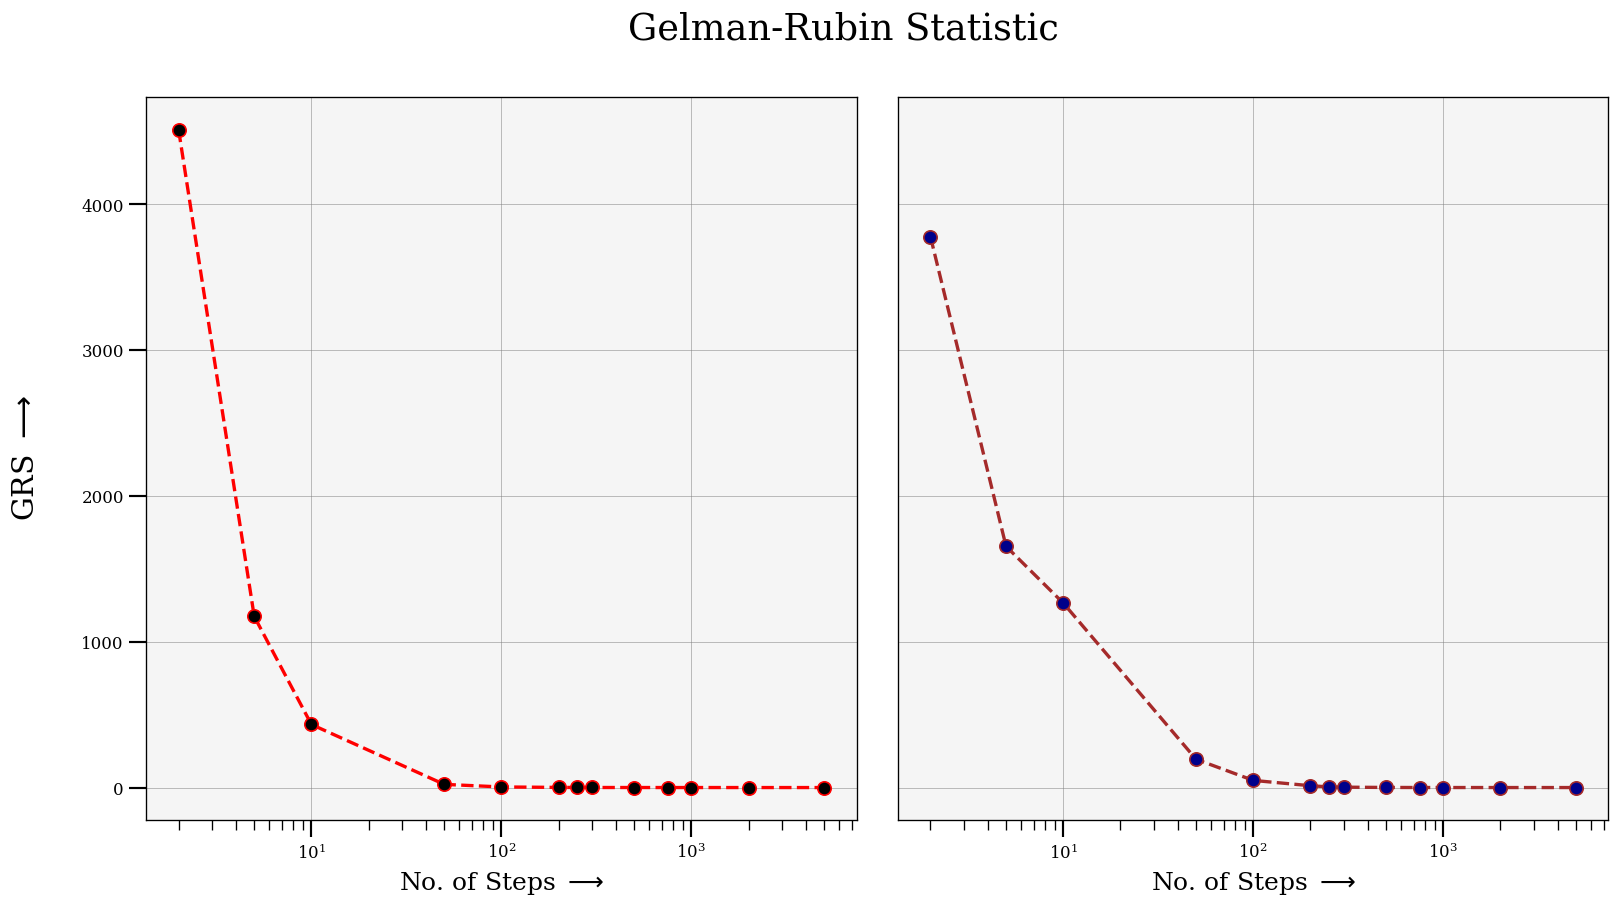

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,
                      figsize=(14,8),dpi=120)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.set_facecolor('whitesmoke')
ax1.semilogx(n_steps_total,grs_h_vals,'ro--',markerfacecolor='k',lw=2.0,ms=8)
ax2.set_facecolor('whitesmoke')
ax2.semilogx(n_steps_total,grs_omega_vals,'o--',color='brown',
            markerfacecolor='darkblue',lw=2.0,ms=8)

fig.suptitle("Gelman-Rubin Statistic",size=22,x=0.52,y=0.965)
fig.supylabel("GRS $\longrightarrow$",size=18,x=2.5e-2)

ax1.tick_params(axis='both',size=10,width=1.3,which='major')
ax1.tick_params(axis='both',size=6,width=0.8,which='minor')

ax2.tick_params(axis='y',size=0,width=1.3,which='major')
ax2.tick_params(axis='x',size=10,width=1.3,which='major')
ax2.tick_params(axis='both',size=6,width=0.8,which='minor')


ax1.set_xlabel("No. of Steps $\longrightarrow$",size=15)
ax2.set_xlabel("No. of Steps $\longrightarrow$",size=15)
plt.tight_layout(pad=2.5)
ax1.grid(color='grey',lw=0.5,alpha=0.6)
ax2.grid(color='grey',lw=0.5,alpha=0.6)